In [51]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

In [1]:
from __future__ import absolute_import, division,\
    print_function, unicode_literals

In [2]:
import tensorflow as tf

In [3]:
tf.enable_eager_execution()

In [4]:
import pathlib
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
from tensorflow import keras
from tensorflow.keras import layers

In [5]:
dataset_path = keras.utils.get_file("auto-mpg.data", \
"http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")

32768/30286 [================================] - 0s 5us/step


In [6]:
dataset_path

'/home/allisonrmcalister/.keras/datasets/auto-mpg.data'

In [8]:
# Import data using pandas
column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower',\
               'Weight', 'Acceleration', 'Model Year', 'Origin']

In [9]:
raw_dataset = pd.read_csv(dataset_path, names=column_names,\
                    na_values='?', comment='\t', sep=' ',\
                    skipinitialspace=True)

In [10]:
dataset = raw_dataset.copy()

In [11]:
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [12]:
# Clean the data
dataset.isna().summ()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [13]:
# Drop rows with n/a
dataset = dataset.dropna()

In [14]:
# Origin is categorical, not numeric.
# Convert "Origin" column to one-hot:
origin = dataset.pop('Origin')

In [15]:
dataset['USA'] = (origin == 1) * 1.0
dataset['Europe'] = (origin == 2)*1.0
dataset['Japan'] = (origin == 3) * 1.0
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


In [17]:
# Split dataset into train and test
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

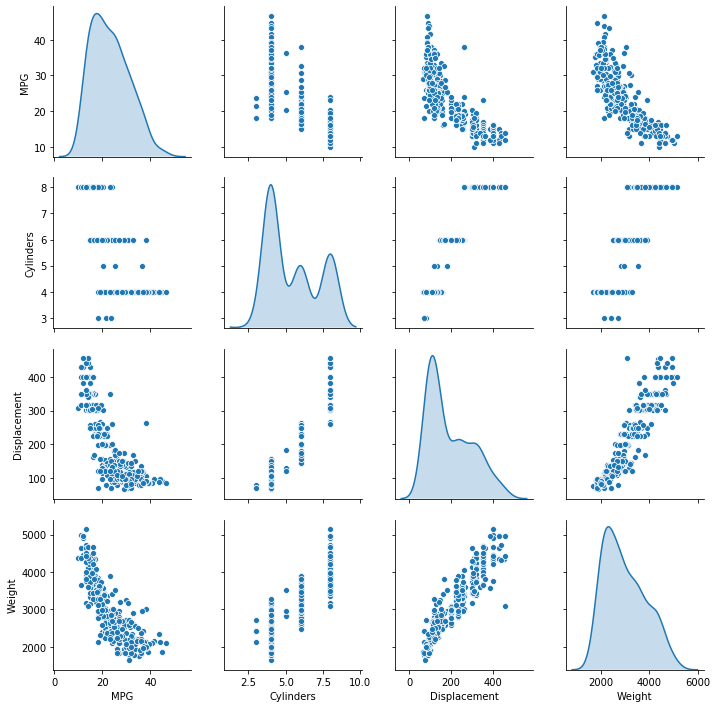

In [18]:
# Inspect data.
sns.pairplot(train_dataset[["MPG", "Cylinders", \
                           "Displacement", "Weight"]], \
                            diag_kind="kde")

In [19]:
# Look at overall stats.
train_stats = train_dataset.describe()

In [20]:
train_stats.pop("MPG")

count    314.000000
mean      23.310510
std        7.728652
min       10.000000
25%       17.000000
50%       22.000000
75%       28.950000
max       46.600000
Name: MPG, dtype: float64

In [21]:
train_stats = train_stats.transpose()

In [22]:
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


In [23]:
# Separate target value (label) from features
train_labels = train_dataset.pop("MPG")
test_labels = test_dataset.pop("MPG")

In [25]:
# Normalize dataset.
def norm(x):
    return (x - train_stats['mean']) / train_stats['std']

In [26]:
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [27]:
# Build model
def build_model():
    model = keras.Sequential([
        layers.Dense(64, activation='relu', \
                     input_shape=[len(train_dataset.keys())]),
        layers.Dense(64, activation='relu'),\
        layers.Dense(1)
    ])
    optimizer = tf.keras.optimizers.RMSprop(0.001)
    model.compile(loss='mse', optimizer=optimizer, \
                  metrics=['mae', 'mse'])
    return model

In [28]:
model = build_model()

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


In [30]:
# Try out the model. Take a batch of 10 examples and predict.
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[-0.1386318 ],
       [ 0.06104854],
       [ 0.2562662 ],
       [-0.02974734],
       [-0.3724603 ],
       [ 0.03217612],
       [-0.38349104],
       [-0.5174148 ],
       [ 0.16989815],
       [-0.28096396]], dtype=float32)

In [31]:
# Train model
# Display training progress by printing a single dot for each
# completed epoch
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

In [32]:
EPOCHS = 1000

In [33]:
history = model.fit(normed_train_data, train_labels,\
                   epochs=EPOCHS, validation_split=0.2, \
                   verbose=0, callbacks=[PrintDot()])


....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
....................................................................................................
..........................................................................................

In [34]:
# Visualize training progress
hist = pd.DataFrame(history.history)

In [35]:
hist['epoch'] = history.epoch

In [36]:
hist.tail

<bound method NDFrame.tail of            loss  mean_absolute_error  mean_squared_error    val_loss  \
0    575.762731            22.658289          575.762695  570.299342   
1    526.795593            21.545132          526.795654  516.732196   
2    475.040153            20.311718          475.040161  455.874298   
3    417.757314            18.907400          417.757324  391.557909   
4    358.210141            17.333147          358.210175  325.505410   
5    296.689248            15.554610          296.689240  259.738483   
6    234.969372            13.685412          234.969360  194.814998   
7    176.476738            11.673779          176.476715  138.367662   
8    124.827759             9.683382          124.827751   91.233456   
9     83.302690             7.698236           83.302696   58.537447   
10    53.648877             5.988530           53.648876   38.383038   
11    35.556215             4.747526           35.556217   28.984398   
12    25.833750             3.9761

In [39]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MPG]')
    plt.plot(hist['epoch'], hist['mean_absolute_error'], label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_absolute_error'], label='Val Error')
    plt.ylim([0,20])
    plt.legend()
    plt.show()

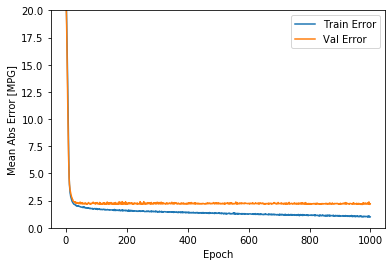

In [40]:
plot_history(history)

In [41]:
# Starts to overfit
model = build_model()

In [42]:
# Patience parameter
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss',\
                                          patience=10)

In [43]:
history = model.fit(normed_train_data, train_labels, \
                    epochs=EPOCHS, validation_split=0.2, \
                   verbose=0, callbacks=[early_stop, PrintDot()])


.....................................................................

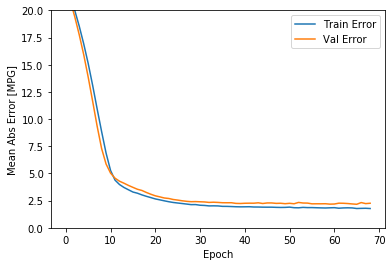

In [44]:
plot_history(history)

In [45]:
# Evaluate model
loss, mae, mse = model.evaluate(normed_test_data, test_labels,\
                               verbose=2)

78/78 - 1s - loss: 5.4840 - mean_absolute_error: 1.7733 - mean_squared_error: 5.4840


In [46]:
print("Testing set Mean Abs Error: {:5.2f} MPG".format(mae))

Testing set Mean Abs Error:  1.77 MPG


In [47]:
# Make predictions
test_predictions = model.predict(normed_test_data).flatten()

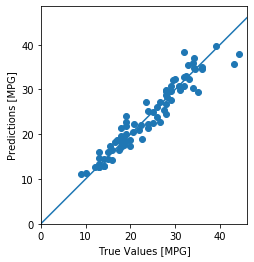

In [48]:
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0, plt.xlim()[1]])
plt.ylim([0, plt.ylim()[1]])
_ = plt.plot([-100,100], [-100,100])

In [49]:
# Predicts pretty well
# Look at error distribution
error = test_predictions - test_labels

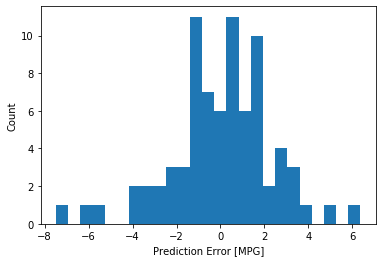

In [50]:
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [MPG]')
_ = plt.ylabel('Count')